### Introduction

In this project, you will be continuing your work with the *Escherichia coli* core model and investigate how the growth phenotype of the model changes when varying one or multiple exchange fluxes (i.e., production envelopes and phenotype phase planes). Additionally, you will be conducting a gene essentiality analysis on the model where the deletion of a gene can be simulated by simply constraining the lower and upper flux bounds of its associated reactions to 0. Gene deletion analysis is a common application of genome-scale metabolic models and allow us to assess the effects of a gene deletion on the metabolic phenotype of an organism before initiating expensive and time-consuming experiments in the lab. I recommend taking a look at the cobrapy documentation before starting with the project, particularly the section on deletion analysis found [here](https://cobrapy.readthedocs.io/en/latest/deletions.html).


In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

from cobra.io import load_model, read_sbml_model 
from cobra.flux_analysis import (production_envelope)
    # single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    # double_reaction_deletion)

In [95]:
ecoli_model = read_sbml_model("ecoli_core_model.xml")
ecoli_model.reactions.get_by_id("EX_o2_e").lower_bound = -1000
ecoli_model.reactions.get_by_id("EX_glc__D_e").upper_bound = 0
ecoli_model.reactions.get_by_id("EX_glc__D_e").lower_bound = -25



### 1.1 Phenotype phase plane analysis

(i) Using the cobrapy function `production_envelope` (see [documentation](https://cobrapy.readthedocs.io/en/latest/phenotype_phase_plane.html)), calculate the growth rate as a function of glucose uptake flux when oxygen is unlimited for the *E. coli* core model. Plot growth vs. glucose uptake flux from 0 to -25 mmol gDW<sup>-1</sup> h<sup>-1</sup> using 40 plot points.

In [116]:
# prod_env = production_envelope(ecoli_model, ["EX_o2_e", "EX_glc__D_e"], objective="EX_glc__D_e", carbon_sources="EX_glc__D_e")
prod_env = production_envelope(ecoli_model, ["EX_glc__D_e"], carbon_sources="EX_glc__D_e", points=40)

In [118]:
# print(prod_env.columns)
prod_env = prod_env.sort_values(by=["EX_glc__D_e"], ascending=False)
# display(prod_env[prod_env["mass_yield_maximum"].notnull()])
# display(prod_env.loc[pd.notnull(prod_env.mass_yield_maximum)])
# display(prod_env.mass_yield_maximum[prod_env.mass_yield_maximum.isnull()])
# prod_env_subset = prod_env[prod_env["carbon_yield_maximum"].notnull()]
prod_env.to_csv("test.csv")
# print(prod_env.carbon_yield_maximum) #[prod_env["mass_yield_maximum"]]

# prod_env.head()


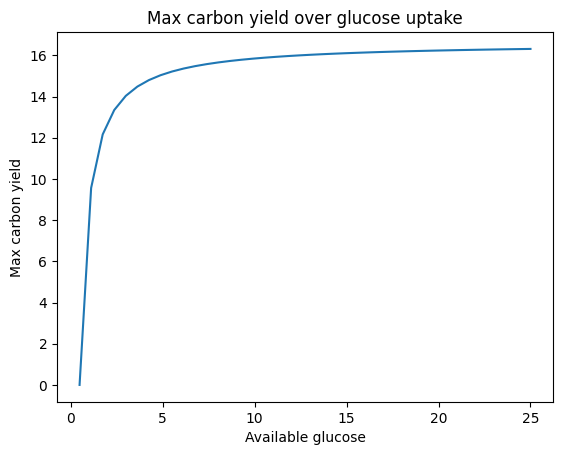

In [133]:

# indx = np.round(indx)
# print(prod_env.shape[0])
# prod_env["index"] = range(0, prod_env.shape[0])
prod_env["EX_glc__D_e.transformed"] = -1*prod_env["EX_glc__D_e"]
chart = sns.lineplot(prod_env, x="EX_glc__D_e.transformed", y="carbon_yield_maximum")
chart.set_title("Max carbon yield over glucose uptake")
chart.set_xlabel("Available glucose")
chart.set_ylabel("Max carbon yield")
plt.show()

(ii) Same as in (i), but now limit the oxygen uptake flux to -10 mmol gDW<sup>-1</sup> h<sup>-1</sup> . Compare and explain the differences with the results from (i).

(iii) Same as in (i) and (ii), but with succinate as the only carbon source. Compare and explain the differences with the results from (i) and (ii). Use the calculated growth rates from Table 1 in Project 3 to argue for your results.

Commonly, we classify the linear segments of the production envelopes by their *shadow prices*, which are defined as

$
\begin{align}
 \pi_i = -\frac{\partial Z}{\partial b_i}.
\end{align}
$

The shadow prices $\pi_i$ defines the sensitivity of the objective function $Z$ to changes in the availability of a given metabolite $i$. $b_i$ defines the violation of the mass balance constraint of metabolite $i$ and is equivalent to an uptake reaction. In other words, it quantitatively describes how the objective function value would change if we could import more of an exchangeable metabolite. A negative $\pi_i$ indicates that increasing the availability of a metabolite $i$ will increase the optimal objective value, while a positive $\pi_i$ indicates that the optimal objective value will decrease.

While production envelopes plotted above are interesting in their own right, it is often more informative to investigate the growth phenotype when adjusting two exchange fluxes simultaneously. This is called phenotype phase plane analysis (PhPP). Rather than forming linear segments, PhPP results in the formation of two-dimensional planes which are defined by their metabolic phenotype and shadow prices of the two variable exchange metabolites.

(iv) Start by plotting a PhPP and associated shadow prices for glucose and oxygen using the *E. coli* core model and the `PhPP` function and associated plotting functions found on Blackboard (`phpp.py`). Use a `flux_range` evenly distributed between 0 and -20 with 50 data points. Note that you will be needing the Python package `palettable`.

We can observe that the shadow prices $\pi_i$ are constant in each of the phase planes. Consequently, we can determine the properties of the different phases by calculating

$
\begin{align}
 \alpha = -\frac{\pi_x}{\pi_y},
\end{align}
$

the ratio between the shadow prices associated with the two exchange fluxes $x$ and $y$ (here, glucose and oxygen). We can then define four types of phases in PhPP:
1. If $\alpha < 0$, the objective function is limited by both exchange fluxes (*dual substrate limitation*).
2. If $\alpha > 0$, the region is called a *futile phase*: one of the exchange substrates will have a positive shadow price. Characterized by wasteful metabolic operations (substrate consumed does not improve $Z$).
3. If either $\pi_x = 0$ or $\pi_y = 0$, the region is described by *single substrate limitation*.
4. *Infeasible phases* due to a combination of stoichiometric limitations and/or substrate availability (no growth).

(v) How many unique phases does this PhPP have? Classify these according to the four types defined above.

(vi) Considering the reasonable assumption of growth optimality, where do you think *E. coli* strains will be located on this PhPP in vivo?

### 1.2 Gene deletion analysis

(i) Conduct a single gene deletion study for all the genes in the *E. coli* core model. Use the default defined nutrient environment (i.e. aerobic glucose).

(a) By making a scatter plot of the relative growth rates (mutant growth / wild type growth) for all gene deletions, define what you consider to be an essential gene.

(b) Identify the name and function of all the essential genes you found. While checking which reactions these genes are associateed with in the model is useful, it can also be an idea to check biochemical databases for informations such as [EcoCyc](https://ecocyc.org/).

(c) Give plausible explanations for why they are essential.

(ii) Change the single carbon source from glucose to acetate and redo the analysis in (a) (no need to go into detail on the function of each gene, comment on the general trend). Also, identify the essential genes that are common to both nutrient environments, and those that are specific to acetate. Explain why this is so.

(iii) Conduct a complete double-gene deletion study of the model in the original nutrient environment.

(a) What is the fraction of essential double-gene knockouts?

(b)  Which genes are involved in the largest number of essential double-knockout combinations? Any idea why?

(iv) Same analysis as in (iii), but this time with acetate as the single carbon source.

(v) Use the results from (i) and (iii) to identify only the synthetic lethal gene combinations. How many are there?

(vi) Select a partial essential gene from (a) (i.e. a gene which when deleted reduces the relative growth rate of the model, but not below the chosen essentiality threshold). Visualize its optimal flux distribution in Escher and compare it to the wild type flux distribution. Discuss and explain the observed differences in flux phenotypes.